In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
#%cd /content/drive/My Drive/Colab Notebooks
df_train = pd.read_csv("SPAM text message 20170820 - Data 2.csv")
df_train.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
list(df_train.columns.values)

x = df_train['Message']
y = df_train['Category']

# label encoder nhãn y để dễ xử lý ['ham','spam'] [0,1]
LE = LabelEncoder() 
label = LE.fit_transform(df_train['Category'])
y = label
print('x:', x.shape,'y:',y.shape)

x: (5572,) y: (5572,)


In [4]:

from gensim import corpora, matutils
# handle text bag of word -> text
SPECIAL_CHARACTER = '0123456789%@$.,=+-!;/()*"&^:#|\n\t\''

# bỏ những kí tự đặc biệt trong message 
def remove_special_character(text): 
    try:
        return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
    except TypeError:
        return []

# xây dựng dictionary từ những message đang có 
def build_dic(x): 
    corpus = []
    for item in x:
        corpus.append(remove_special_character(item))
    dct = corpora.Dictionary(corpus)
    dct.filter_extremes(no_below=5, no_above=0.76)
    return dct

dct = build_dic(x)

In [5]:

# chuyển doc to vector
def get_dense(text, dictionary): 
    words = remove_special_character(text)
    # Bag of words
    vec = dct.doc2bow(words)  
    dense = list(matutils.corpus2dense([vec], num_terms=len(dictionary)).T[0])
    return dense

X_train = []
y_train = y
for item in x:
    X_train.append(get_dense(item,dct))

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
(X_train,X_test, y_train, y_test) = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('X_train',X_train.shape,'y_train',y_train.shape) 
print('X_test',X_test.shape,'y_test',y_test.shape) 

X_train (4457, 1767) y_train (4457,)
X_test (1115, 1767) y_test (1115,)


Hàm loss softmax<br> 
![losss](losss.png "Title")
Hàm đạo hàm theo w <br>
![derative](derative.png "Title")
Cross entropy
<img src="https://cdn-images-1.medium.com/max/1000/1*lUUmNbjMNS1rfX4El9i5VA.png" width="30%">

Soft max function <br>
![softmax](softmax.png "Soft max thông thường")
Tối ưu soft max function <br>
![softmax_toiuu](softmax_toiuu.png "Soft max stable hơn")

In [7]:
# hàm softmax trả về xác suất xuất hiện của từng giá trị trên tập dự liệu z 
# hàm softmax stable cũng như hàm z 
# hay còn gọi là sự phân phối của mỗi dữ liệu trong dòng dữ liệu đó
def softmax_stable(z): 
    z -= np.max(z) 
    sm_stable = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm_stable

def softmax(z): 
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [8]:
def oneHotIt(Y):
    m = Y.shape[0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T 
    return OHX

In [9]:
def getLoss(w,x,y):
    m = x.shape[0] # Lấy độ dài document
    y_mat = oneHotIt(y) # OneHot encoding y
    scores = np.dot(x,w) # tính z = x*w 
    prob = softmax_stable(scores) # tính xác suất của mỗi tài liệu theo hàm softmax stable 
    loss = (-1 / m) *np.sum(np.multiply(y_mat,prob)) + np.log(np.sum(np.exp(prob))) # công thức loss của hàm soft max theo entropy
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) # tính đạo hàm của loss theo w 
    return loss,grad

In [148]:
w = np.zeros([X_train.shape[1],len(np.unique(y_train))])
lam = 1
iterations = 1000
learningRate = 0.1
losses = []
# cập nhật w theo gradient descent
for i in range(0,iterations):
    loss,grad = getLoss(w,X_train,y_train)
    losses.append(loss)
    if i % 100 == 0:
        print('with i:',i,' - loss:',loss)
    w = w - (learningRate * grad) 
print(loss,w)

with i: 0  - loss: 9.0953783535065
with i: 100  - loss: 8.890092687259338
with i: 200  - loss: 8.858431863291024
with i: 300  - loss: 8.841741920454634
with i: 400  - loss: 8.830807157527243
with i: 500  - loss: 8.822873759990326
with i: 600  - loss: 8.816733945201543
with i: 700  - loss: 8.811772244661046
with i: 800  - loss: 8.80763775681634
with i: 900  - loss: 8.804113464184603
8.80108501446126 [[ 0.0260534  -0.0260534 ]
 [ 0.02765465 -0.02765465]
 [ 0.01615836 -0.01615836]
 ...
 [ 0.02219393 -0.02219393]
 [ 0.00358244 -0.00358244]
 [ 0.00701706 -0.00701706]]


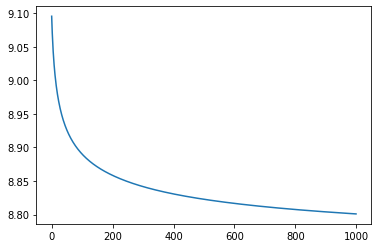

In [149]:
#so sánh dự đoán giữa tập predict và đúng 
def getAccuracy(someX,someY):
    prob,prede = getProbsAndPreds(someX)
    accuracy = sum(prede == someY)/(float(len(someY)))
    return accuracy
plt.plot(losses)

In [0]:
# predict và xác suất sinh ra class đó 
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [126]:
print('Training Accuracy: ', getAccuracy(X_train,y_train))
print('Test Accuracy: ', getAccuracy(X_test,y_test))

Training Accuracy:  0.9398698676239623
Test Accuracy:  0.9345291479820628


In [131]:
# test trên 1 tài liệu
probs = softmax(np.dot([get_dense(x[2],dct)],w))
# probs => 19% thuộc class 1 , gần 81% thuộc class 2


Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 1


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [141]:
# test trên 10 tài liệu
for index,text in enumerate(x[:10]):
    probs = softmax(np.dot([get_dense(text,dct)],w))
    print("Tin nhắn dùng để test:",text)
    print("Mong muốn:",LE.classes_[y[index]])
    print("Kết quả classify:",LE.classes_[np.argmax(probs,axis=1)][0])
    print()
    print()

Tin nhắn dùng để test: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mong muốn: ham
Kết quả classify: ham


Tin nhắn dùng để test: Ok lar... Joking wif u oni...
Mong muốn: ham
Kết quả classify: ham


Tin nhắn dùng để test: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mong muốn: spam
Kết quả classify: spam


Tin nhắn dùng để test: U dun say so early hor... U c already then say...
Mong muốn: ham
Kết quả classify: ham


Tin nhắn dùng để test: Nah I don't think he goes to usf, he lives around here though
Mong muốn: ham
Kết quả classify: ham


Tin nhắn dùng để test: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Mong muốn: spam
Kết quả classify: ham


Tin nhắn dùng để test: Even my brother is not like to speak with me

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)
